# **Part A**
Count / Frequency based Naive Bayes Classifier

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # Calculate the log prior and store it in self.class_priors[c]
            # P(C) = (Number of samples in class c) / (Total number of samples)
            self.class_priors[c] = np.log(X_c.shape[0] / len(y_array))

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # Apply Laplace smoothing
            # P(w_i | C) = (count(w_i, C) + alpha) / (total_words_in_C + alpha * vocab_size)
            
            # Calculate the numerator (with Laplace smoothing)
            numerator = feature_sum + self.alpha
            
            # Calculate the denominator (with Laplace smoothing)
            denominator = total_mass + self.alpha * self.vocabulary_size
            
            # Calculate the log likelihood
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}
            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # Add log likelihoods contribution
                # log_prob += sum(count(w_i) * log(P(w_i|C)))
                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])
                scores[c] = log_prob

            # Find the class label with the maximum score
            predicted_class = max(scores, key=scores.get)
            y_pred.append(predicted_class)

        return np.array(y_pred)

In [8]:
dir_path = './Dataset'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [9]:
if X_train is not None and len(X_train) > 0:
    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        ngram_range=(1, 2),  # Unigrams and bigrams
        min_df=5  # Minimum document frequency
    )

    print("Fitting Count Vectorizer and transforming training data...")
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    X_test_counts = count_vectorizer.transform(X_test)

    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")
    nb_model = NaiveBayesClassifier(alpha=1.0)
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")

Fitting Count Vectorizer and transforming training data...
Vocabulary size: 86557
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [10]:
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")


=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7483
              precision    recall  f1-score   support

  BACKGROUND       0.54      0.57      0.55      3621
 CONCLUSIONS       0.61      0.70      0.66      4571
     METHODS       0.83      0.85      0.84      9897
   OBJECTIVE       0.53      0.51      0.52      2333
     RESULTS       0.88      0.78      0.83      9713

    accuracy                           0.75     30135
   macro avg       0.68      0.69      0.68     30135
weighted avg       0.76      0.75      0.75     30135

Macro-averaged F1 score: 0.6809


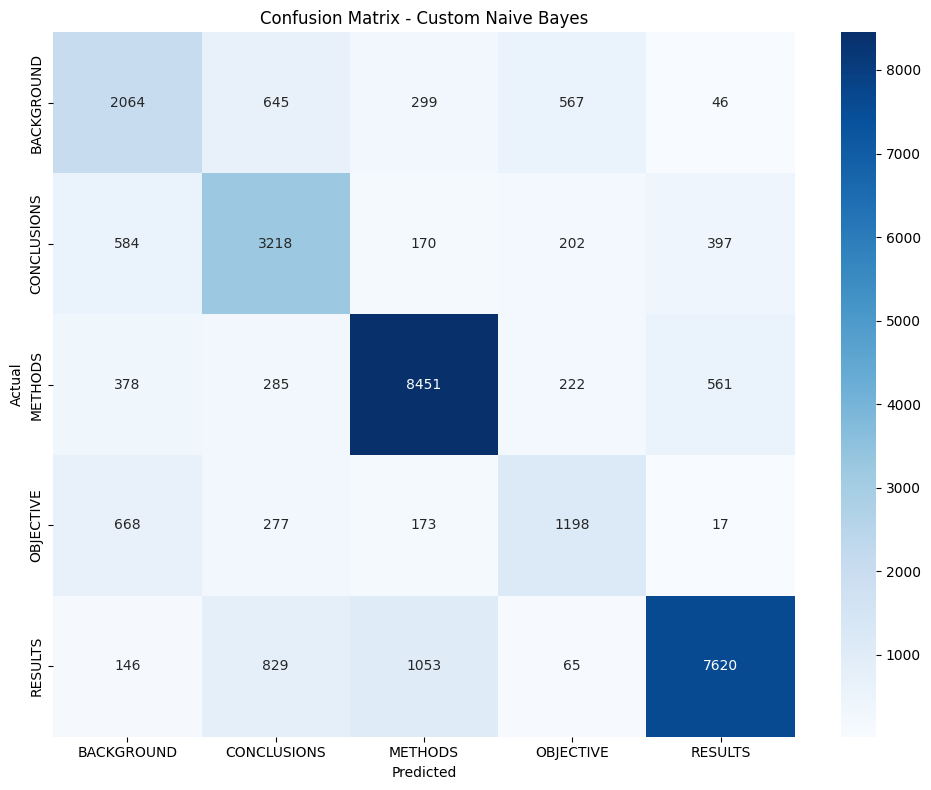

In [11]:
if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Custom Naive Bayes')
    plt.tight_layout()
    plt.show()

# **Part B**
TF-IDF score based Classifier

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Implement the following steps:
# 1. Define the initial `pipeline` combining TfidfVectorizer and MultinomialNB with default parameters.
# 2. Train the initial pipeline on the training data (X_train, y_train).
# 3. Predict and evaluate the performance of the initial model on the test data (X_test, y_test).
# 4. Define the `param_grid` for hyperparameter tuning.
# 5. Initialize `GridSearchCV` using the pipeline, parameter grid, and appropriate cross-validation settings.
# 6. Fit the Grid Search object using the development data (X_dev, y_dev).
# 7. Print the `best_params_` and `best_score_` found by the grid search.
# =======================================================


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Define a Pipeline using TfidfVectorizer and MultinomialNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True, strip_accents='unicode', 
                              stop_words='english')),
    ('nb', MultinomialNB())
])

# Train the initial pipeline on the training set
print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")

# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
else:
    print("Initial model evaluation skipped: Predictions not available.")

# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__min_df': [3, 5, 10],
    'nb__alpha': [0.1, 0.5, 1.0, 2.0]
}

# Initialize GridSearchCV
# Note: Use n_jobs=1 on Windows to avoid multiprocessing issues
grid = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=3, 
    scoring='f1_macro',
    n_jobs=1,  # Changed from -1 to 1 for Windows compatibility
    verbose=1
)

print("\nStarting Hyperparameter Tuning on Development Set...")
grid.fit(X_dev, y_dev)
print("Grid search complete.")

if grid is not None and hasattr(grid, 'best_params_'):
    print(f"\nBest parameters: {grid.best_params_}")
    print(f"Best cross-validation F1 score: {grid.best_score_:.4f}")
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")

Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.6996
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.37      0.46      3621
 CONCLUSIONS       0.61      0.55      0.57      4571
     METHODS       0.68      0.88      0.77      9897
   OBJECTIVE       0.72      0.09      0.16      2333
     RESULTS       0.77      0.85      0.81      9713

    accuracy                           0.70     30135
   macro avg       0.68      0.55      0.56     30135
weighted avg       0.69      0.70      0.67     30135

Macro-averaged F1 score: 0.5555

Starting Hyperparameter Tuning on Development Set...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Grid search complete.

Best parameters: {'nb__alpha': 0.1, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}
Best cross-validation F1 score: 0.6308


# **Part C**
Bayes Optimal Classifier

Part C Draft

Using dynamic sample size: 10337
Actual sampled training set size used: 10337

Training all base models...
Training NaiveBayes...
Training LogisticRegression...


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Training RandomForest...
Training DecisionTree...
Training KNN...
All base models trained.

Computing posterior weights...
NaiveBayes: Log-likelihood = -1622.90
LogisticRegression: Log-likelihood = -1480.63
RandomForest: Log-likelihood = -1745.97
DecisionTree: Log-likelihood = -2496.38
KNN: Log-likelihood = -2667.50

Posterior weights:
NaiveBayes: 0.0000
LogisticRegression: 1.0000
RandomForest: 0.0000
DecisionTree: 0.0000
KNN: 0.0000

Fitting the VotingClassifier (BOC approximation)...


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.7090
              precision    recall  f1-score   support

  BACKGROUND       0.55      0.37      0.44      3621
 CONCLUSIONS       0.61      0.56      0.58      4571
     METHODS       0.71      0.89      0.79      9897
   OBJECTIVE       0.66      0.35      0.45      2333
     RESULTS       0.80      0.81      0.80      9713

    accuracy                           0.71     30135
   macro avg       0.66      0.60      0.61     30135
weighted avg       0.70      0.71      0.69     30135

Macro-averaged F1 score: 0.6146


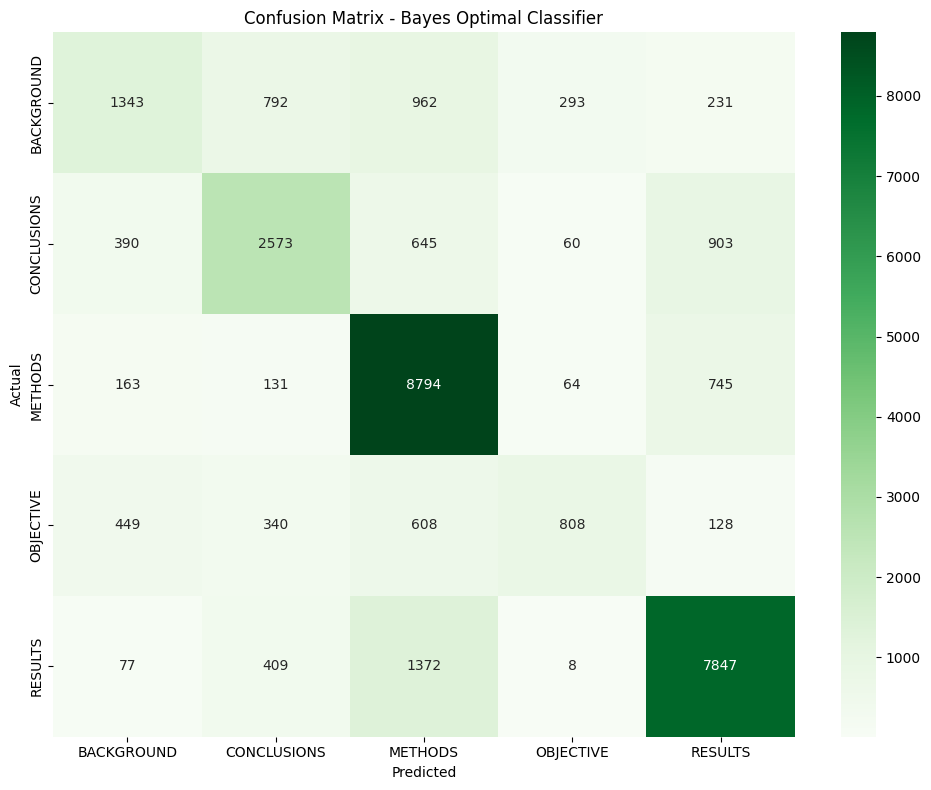

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split # Used for P(h|D) calculation

# =======================================================
# TODO: Implement the following steps:
# 1. Train all five hypotheses on the sampled training data.
# 2. Compute the Posterior Weights P(h_i | D) using a validation split.
# 3. Fit the VotingClassifier using the sampled training data.
# 4. Make final predictions and evaluate the BOC performance on the test data.
# =======================================================

# Dynamic Data Sampling
BASE_SAMPLE_SIZE = 10000
FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value
print(f"Using dynamic sample size: {SAMPLE_SIZE}")

if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")

# Base TF-IDF parameters
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 5
}

# Define the five diverse hypotheses/pipelines
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
])

h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=1), 
        cv=3, method='isotonic'
    ))
])

h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42), 
        cv=3, method='isotonic'
    ))
])

h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=1), 
        cv=3, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']

# Train all five hypotheses
print("\nTraining all base models...")
for i, (name, model) in enumerate(zip(hypothesis_names, hypotheses)):
    print(f"Training {name}...")
    model.fit(X_train_sampled, y_train_sampled)
print("All base models trained.")

# Compute Posterior Weights P(h_i | D)
print("\nComputing posterior weights...")
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, random_state=42
)

log_likelihoods = []
for i, model in enumerate(hypotheses):
    # Get probability predictions on validation set
    y_val_proba = model.predict_proba(X_val_sub)
    
    # Calculate log-likelihood
    epsilon = 1e-10  # Small value to avoid log(0)
    log_likelihood = 0
    for j, true_label in enumerate(y_val_sub):
        class_index = list(model.classes_).index(true_label)
        log_likelihood += np.log(y_val_proba[j][class_index] + epsilon)
    
    log_likelihoods.append(log_likelihood)
    print(f"{hypothesis_names[i]}: Log-likelihood = {log_likelihood:.2f}")

# Convert log-likelihoods to weights using softmax
log_likelihoods = np.array(log_likelihoods)
exp_log_likelihoods = np.exp(log_likelihoods - np.max(log_likelihoods))
posterior_weights = exp_log_likelihoods / np.sum(exp_log_likelihoods)

print("\nPosterior weights:")
for name, weight in zip(hypothesis_names, posterior_weights):
    print(f"{name}: {weight:.4f}")

# Implement and Evaluate the Bayes Optimal Classifier
estimators = list(zip(hypothesis_names, hypotheses))

boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=1  # Changed from -1 to 1 for Windows compatibility
)

print("\nFitting the VotingClassifier (BOC approximation)...")
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")

# Make the final BOC prediction on the test set
print("\nPredicting on test set...")
y_pred = boc_soft_voter.predict(X_test)

# Final Evaluation
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")

if y_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_pred, average='macro'):.4f}")
    
    # Generate and visualize the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Bayes Optimal Classifier')
    plt.tight_layout()
    plt.show()
else:
    print("Evaluation skipped: Predictions not generated.")